In [1]:
import pandas as pd
import datetime as dt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
# Load and preprocess data
start = dt.datetime(2021, 7, 1)
end = dt.datetime(2022, 1, 27)
symbol = 'AXISBANK.NS'

stk_data = yf.download(symbol, start=start, end=end)
stk_data = stk_data[["Close"]]

[*********************100%%**********************]  1 of 1 completed


In [3]:
stk_data

,Close
Date,
2021-07-01,746.450012
2021-07-02,750.650024
2021-07-05,760.349976
2021-07-06,758.349976
2021-07-07,762.900024
...,...
2022-01-19,729.599976
2022-01-20,728.900024
2022-01-21,712.500000


In [4]:
# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(stk_data[["Close"]])

In [5]:
# Train SARIMAX model
orders = [(0,0,0), (0,0,1), (2,0,1), (1,1,1)]
best_order = None
best_rmse = float('inf')
best_model_fit = None

In [6]:
def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

for order in orders:
    model = SARIMAX(data_scaled, order=order, seasonal_order=(0, 0, 0, 12))
    model_fit = model.fit(disp=False)
    y_pred = model_fit.predict(0, len(data_scaled) - 1)
    error = rmse(data_scaled, y_pred)
    print(f'Order: {order}, RMSE: {error}')
    if error < best_rmse:
        best_rmse = error
        best_order = order
        best_model_fit = model_fit

print(f'Best order: {best_order}, RMSE: {best_rmse}')


Order: (0, 0, 0), RMSE: 0.5317706652449596
Order: (0, 0, 1), RMSE: 0.28836746864706203


C:\Users\udhaya\Anaconda3\envs\aim1\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order: (2, 0, 1), RMSE: 0.07236959087427292
Order: (1, 1, 1), RMSE: 0.07246463957334504
Best order: (2, 0, 1), RMSE: 0.07236959087427292


In [7]:
# Predictions
y_pred_scaled = best_model_fit.predict(0, len(data_scaled) - 1)

# Inverse transform predictions
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
actual_stock_price = scaler.inverse_transform(data_scaled)


In [12]:
actual_stock_price

array([[746.45001221],
       [750.65002441],
       [760.34997559],
       [758.34997559],
       [762.90002441],
       [754.40002441],
       [747.34997559],
       [753.59997559],
       [770.75      ],
       [770.04998779],
       [774.15002441],
       [771.15002441],
       [755.20001221],
       [745.75      ],
       [746.75      ],
       [755.40002441],
       [756.29998779],
       [731.70001221],
       [722.90002441],
       [717.25      ],
       [708.90002441],
       [721.15002441],
       [738.59997559],
       [753.79998779],
       [749.29998779],
       [740.84997559],
       [755.5       ],
       [761.54998779],
       [760.79998779],
       [757.34997559],
       [759.90002441],
       [762.        ],
       [756.75      ],
       [754.40002441],
       [740.25      ],
       [736.09997559],
       [746.34997559],
       [739.04998779],
       [746.34997559],
       [752.40002441],
       [784.04998779],
       [786.5       ],
       [798.90002441],
       [802

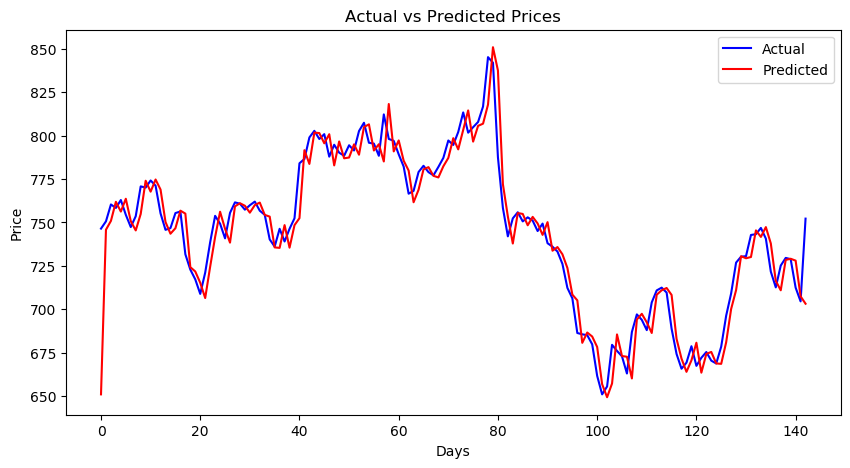

In [8]:
# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(actual_stock_price, color='blue', label='Actual')
plt.plot(y_pred, color='red', label='Predicted')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


In [9]:
# Forecast future values
forecast_scaled = best_model_fit.get_forecast(steps=2)
forecast_scaled_values = forecast_scaled.predicted_mean
forecast_values = scaler.inverse_transform(forecast_scaled_values.reshape(-1, 1))

In [13]:
forecast_values

array([[764.95920589],
       [763.76647873]])

Forecasted Prices: [[764.95920589]
 [763.76647873]]


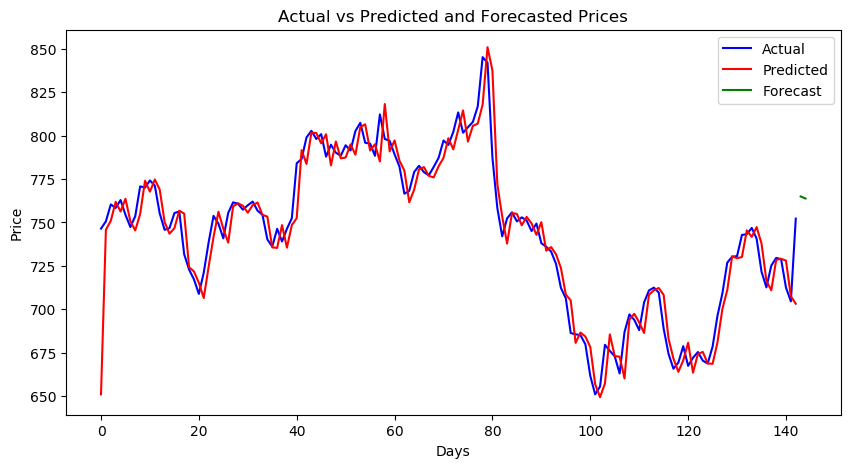

In [10]:
print("Forecasted Prices:", forecast_values)

# Plot actual, predicted, and forecasted values
plt.figure(figsize=(10,5))
plt.plot(actual_stock_price, color='blue', label='Actual')
plt.plot(y_pred, color='red', label='Predicted')
plt.plot(range(len(actual_stock_price), len(actual_stock_price) + len(forecast_values)), 
         forecast_values, color='green', label='Forecast')
plt.title('Actual vs Predicted and Forecasted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


In [11]:

# Save forecast to CSV
forecast_df = pd.DataFrame(forecast_values, columns=["Forecasted Close"])
forecast_df.to_csv("forecasted_prices.csv", index=False)